In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from statistics import mean
import math
import statistics

In [ ]:
path = input("Are you Katherine (K) or someone else (S)?")
if(path == 'K'):
  df = pd.read_csv("/content/drive/MyDrive/MedIX - Subtype Discovery Project/Code/notebooks we are actually using LOL/SPIE Extended Abstract Results/Copy of MaxSlices_newMode_2022.csv")
elif path == 'S':
  pathSomeoneElse = input("Please copy the path where you have the MaxSlicesPerNodule file and paste that path here:")
  df = pd.read_csv(pathSomeoneElse)

Are you Katherine (K) or someone else (S)?K


In [ ]:

df = df.drop(['RadiologistID', 'SeriesInstanceUid', 'StudyInstanceUID', 'FilePath', 'DicomImage', 'imageSOP_UID','coords', 'Subtlety_1', 'InternalStructure_1', 'Sphericity_1', 'Margin_1', 'Lobulation_1', 'Spiculation_1', 'Texture_1', 'Malignancy_1', 'Subtlety_2', 'InternalStructure_2', 'Sphericity_2', 'Margin_2', 'Lobulation_2', 'Spiculation_2', 'Texture_2', 'Malignancy_2', 'Subtlety_3', 'InternalStructure_3', 'Sphericity_3', 'Margin_3', 'Lobulation_3', 'Spiculation_3', 'Texture_3', 'Malignancy_3', 'Subtlety_4', 'InternalStructure_4', 'Sphericity_4', 'Margin_4', 'Lobulation_4', 'Spiculation_4', 'Texture_4', 'Malignancy_4', 'Subtlety', 'InternalStructure', 'Sphericity', 'Margin', 'Lobulation', 'Spiculation', 'Texture'], axis=1)

In [ ]:
df = df.drop(['Calcification_1', 'Calcification_2', 'Calcification_3', 'Calcification_4', 'Calcification'], axis = 1)

In [ ]:
lidc = df

In [ ]:
lidc = lidc[lidc.Malignancy != 3.0]
for i, row in lidc.iterrows():
    ifor_val = 0
    if row['Malignancy'] == 4.0 or row['Malignancy'] == 5.0:
      ifor_val = 1
    lidc.at[i,'Malignancy'] = ifor_val

In [ ]:
!pip install umap-learn
import umap.umap_ as umap
X_with_id = lidc
y = (lidc['Malignancy']).to_numpy()
X = X_with_id.drop(['noduleID', 'Malignancy'], axis = 1)
print(X.columns)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
pca = umap.UMAP()
X = pca.fit_transform(X)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Index(['InstanceID', 'imageZposition', 'PixelSpacing', 'PixelArea', 'Area',
       'ConvexArea', 'Perimeter', 'ConvexPerimeter', 'EquivDiameter',
       'MajorAxisLength', 'MinorAxisLength', 'SuperscribedDiameter',
       'Elongation', 'Compactness', 'Eccentricity', 'Solidity', 'Extent',
       'Circularity', 'RadialDistanceSD', 'SecondMoment', 'Roughness',
       'MinIntensity', 'MaxIntensity', 'MeanIntensity', 'SDIntensity',
       'MinIntensityBG', 'MaxIntensityBG', 'MeanIntensityBG', 'SDIntensityBG',
       'IntensityDifference', 'markov1', 'markov2', 'markov3', 'markov4',
       'markov5', 'gabormean_0_0', 'gaborSD_0_0', 'gabormean_0_1',
       'gaborSD_0_1', 'gabormean_0_2', 'gaborSD_0_2', 'gabormean_1_0',
       'gaborSD_1_0', 'gabormean_1_1', 'gaborSD_1_1', 'gabormean_1_2',
       'gaborSD_1_2', 'gabormean_2_0', 'gaborSD_2_0', 'gabormean_2_1',
       'gaborSD_2_1', 'gabormean_2_2'

In [ ]:
print(len(X)) #Length reduced because indeterminate nodules were removed

1491


In [ ]:
def createList(r1, r2):
    return [item for item in range(r1, r2)]
# Driver Code
r1, r2 = 0, len(y)
lstOfIds = createList(r1, r2)

In [ ]:
def calculateHomogeneity(predicted, actual, origNumLabels = 2):

  numPredictedClusters = len(np.unique(predicted)) # number of predicted clusters
  numActual = len(np.unique(actual)) # number of actual ground truth classes

  clusterHomogeneities = []
  clusterTotals = []
  for i in range(numPredictedClusters):
    homogeneityList = np.zeros(origNumLabels)
    # find all of the indices of the cluster
    ind = np.where(np.isin(predicted,i))
    actual = np.array(actual)
    actualVals = actual[ind] # finding the actual values in that cluster
    totalNumInCluster = len(actualVals) # finding the amount of points in that cluster in order to divide
    clusterTotals.append(totalNumInCluster)
    for i in actualVals:
      homogeneityList[i-1] = homogeneityList[i-1] + 1
    homogeneityList = homogeneityList / totalNumInCluster
    clusterHomogeneities.append(max(homogeneityList))
  return [clusterHomogeneities, clusterTotals]

In [ ]:
def iterativeClustering(threshold, data, actual, IdList, centers = [], properlyClassified = [], hsOfRemoved = [], lengthOfData = len(X)):
 
  print("Number of data points to work with: ", data.shape[0])

  #finding the best k

  k = 1;
  currHomogeneity = 0.0;
  while (currHomogeneity < threshold and k <= math.sqrt(lengthOfData/2)):
    k = k + 1
    model = sk.cluster.KMeans(n_clusters = k)
    clusterLabels = model.fit_predict(data)
    clusterCenters = model.cluster_centers_ # getting the centers of the clusters
    homogeneityList = calculateHomogeneity(clusterLabels, actual) 
    currHomogeneity = np.max(homogeneityList[0])
  

  predLabels = clusterLabels
  homogeneityPCluster = homogeneityList[0]
  
  for i in range(k):
    print("Homogeneity of cluster {} is {}".format(i,homogeneityPCluster[i]))
  
  #find clusters to remove
  clustersToRemove = []
  bestClusterHS = currHomogeneity
  print("this is the maximum homogeneity: {}".format(bestClusterHS))
  indexOfMax = homogeneityPCluster.index(bestClusterHS) 
  clusterTotals = homogeneityList[1]
  for i in range(k):
    diffBtwnBest = bestClusterHS - homogeneityPCluster[i]
    
    if i == indexOfMax:
      clustersToRemove.append(i)
      
      print("Cluster sectioned off:", i)
      continue
    if diffBtwnBest < .03 and homogeneityPCluster[i] >= threshold and clusterTotals[i]> math.sqrt(len(data)):
      
      clustersToRemove.append(i)
      
      print("Cluster sectioned off:", i)

  pointsRemoved = 0
  totalPoints = sum(clusterTotals)
  for i in range(k):
    if i in clustersToRemove:
      pointsRemoved += clusterTotals[i]

  
  remainingDatapoints = totalPoints - pointsRemoved #check total points
  print("percent removed: {}".format(pointsRemoved/lengthOfData))
  if remainingDatapoints < math.sqrt(lengthOfData) or (pointsRemoved <= math.sqrt(len(data))): 
    if remainingDatapoints < math.sqrt(lengthOfData):
      print("Too few remaining points.")
    else:
      print("Two few points in a cluster.")
    print("DONE - we have all clusters")
    return list(properlyClassified), list(IdList), list(hsOfRemoved), list(centers)

  else: 
    #remove these dataPoints in cluster chosen to be separated
    #recluster remaining
    IdList = np.array(IdList)

    for num in clustersToRemove:
      indices = np.where(np.isin(predLabels,num))
      toAppend = IdList[indices]
      properlyClassified.append(toAppend)
      centers.append(clusterCenters[num])
      hsOfRemoved.append(homogeneityPCluster[num])
      data = np.delete(data, indices, axis=0)
      actual = np.delete(actual, indices)
      IdList = np.delete(IdList,indices)
      predLabels = np.delete(predLabels,indices)
    
    print("Good clusters removed. Starting over with smaller dataset.")
    return iterativeClustering(threshold, data, actual,IdList, centers, properlyClassified, hsOfRemoved)

In [ ]:
separatedClusters, remainingPoints, scores, centers = iterativeClustering(.8, X,y,lstOfIds)

Number of data points to work with:  1491
Homogeneity of cluster 0 is 0.9185714285714286
Homogeneity of cluster 1 is 0.7013888888888888
Homogeneity of cluster 2 is 0.5774647887323944
this is the maximum homogeneity: 0.9185714285714286
Cluster sectioned off: 0
percent removed: 0.4694835680751174
Good clusters removed. Starting over with smaller dataset.
Number of data points to work with:  791
Homogeneity of cluster 0 is 0.9081885856079405
Homogeneity of cluster 1 is 0.5774647887323944
Homogeneity of cluster 2 is 0.7941176470588235
Homogeneity of cluster 3 is 0.5335689045936396
this is the maximum homogeneity: 0.9081885856079405
Cluster sectioned off: 0
percent removed: 0.2702883970489604
Good clusters removed. Starting over with smaller dataset.
Number of data points to work with:  388
Homogeneity of cluster 0 is 0.5915492957746479
Homogeneity of cluster 1 is 0.5774647887323944
Homogeneity of cluster 2 is 0.7941176470588235
Homogeneity of cluster 3 is 0.9583333333333334
Homogeneity of 

In [ ]:
# checking the amount of subtypes and the amount of unclustered points
print(len(separatedClusters))
print(len(remainingPoints))

6
267


In [ ]:
# checking number of points in a cluster
for i in separatedClusters:
  print(len(i))

700
403
24
32
35
30


In [ ]:
#finding nodule IDs of the closest points to cluster centers, in case you want to visualize the images of the clusters
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(centers, X)
for i in closest:
  print(lidc.iloc[i]['noduleID'])

745.0
1816.0
134.0
2651.0
1344.0
2596.0


In [ ]:
#Calculating homogeneity of unclustered points
labels = y
numLabelsPerClass = {}

for i in remainingPoints:
  label = labels[i]
  if label in numLabelsPerClass:
    numLabelsPerClass[label] += 1
  else:
    numLabelsPerClass[label] = 1

hsPClass = [] #HS per class in unclustered
for key in numLabelsPerClass:
  homogeneity = (numLabelsPerClass[key]/len(remainingPoints))
  hsPClass.append(homogeneity)

hsWoUnclustered = scores
print(scores)
print(mean(scores))
hsWUnclustered = hsWoUnclustered
hsWUnclustered.append(max(hsPClass))
print(mean(hsWUnclustered))
print(hsWUnclustered)

[0.9185714285714286, 0.9081885856079405, 0.9583333333333334, 1.0, 0.8, 0.8333333333333334]
0.9030711134743393
0.8462920940534465
[0.9185714285714286, 0.9081885856079405, 0.9583333333333334, 1.0, 0.8, 0.8333333333333334, 0.5056179775280899]


In [ ]:
model = sk.cluster.KMeans(n_clusters = len(separatedClusters))
clusterLabels = model.fit_predict(X)
centersForTrad = model.cluster_centers_
# Homogeneity Scores for Traditional Clustering w/ num subtypes from Iterative
lst = calculateHomogeneity(clusterLabels,y)
print(lst[0])
print(len(lst[0]))
print("Average homogeneity for TRADITIONAL clustering: ", mean(lst[0]))

[0.9883720930232558, 0.6084507042253521, 0.7941176470588235, 0.5774647887323944, 0.9103139013452914, 0.9055690072639225]
6
Average homogeneity for TRADITIONAL clustering:  0.7973813569415066


In [ ]:
# Finds labels in the dataframe of separated and remaining points

labelsForEverything = np.zeros(len(X))
labelForRemaining = len(separatedClusters)

for label in range(len(separatedClusters)):
  for index in separatedClusters[label]:
    labelsForEverything[index] = label


for index in remainingPoints: 
  labelsForEverything[index] = labelForRemaining

indices = np.where(labelsForEverything==labelForRemaining)
print(indices)

copyOfX = X
XRemoved = np.delete(copyOfX,indices[0],axis=0)

copyOfEverything = labelsForEverything
labelsForRemoved = np.delete(copyOfEverything,indices[0])

(array([  77,   85,   86,   87,  103,  118,  120,  128,  129,  133,  134,
        135,  136,  148,  150,  158,  159,  160,  169,  173,  185,  186,
        187,  188,  205,  211,  218,  221,  229,  233,  235,  237,  250,
        251,  258,  261,  270,  271,  273,  274,  278,  281,  292,  305,
        307,  309,  310,  320,  325,  335,  375,  376,  380,  395,  396,
        399,  404,  408,  410,  418,  423,  433,  435,  457,  465,  466,
        467,  468,  470,  473,  474,  476,  478,  479,  480,  481,  485,
        489,  492,  493,  494,  514,  518,  521,  523,  530,  531,  537,
        539,  540,  541,  545,  548,  555,  559,  560,  568,  573,  574,
        575,  576,  578,  579,  580,  581,  582,  587,  605,  610,  612,
        618,  624,  629,  631,  640,  641,  642,  653,  659,  663,  666,
        702,  706,  718,  720,  722,  739,  751,  752,  759,  763,  764,
        778,  779,  780,  803,  805,  807,  808,  815,  824,  825,  838,
        839,  840,  841,  849,  850,  856,  857,  

In [ ]:
def getIds(X_test):
  indexLst = []
  for lst in X_test:
    index = int(lst[-1])
    indexLst.append(index)
  return indexLst

In [ ]:
# custom metric to define the number of points misclassified per cluster, using majority class in the cluster as the label
from scipy import stats
def findMisclassified(X, X_test, y, y_test,listOfIndices): 
  numMisclassified = []
  indicesInX = listOfIndices
  groundTruths = [y[i] for i in indicesInX]
  for i in np.unique(y_test):
    numMisclassifiedPerCluster = 0
    indicesOfInterest = np.where(y_test == i)[0]
    truthLabels = [groundTruths[i] for i in indicesOfInterest]
    majorityClassLabel = int(stats.mode(truthLabels)[0])
    for i in truthLabels:
      if i!=majorityClassLabel:
        numMisclassifiedPerCluster = numMisclassifiedPerCluster + 1
    numMisclassified.append(numMisclassifiedPerCluster)
  return numMisclassified

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, balanced_accuracy_score, recall_score, precision_score

In [ ]:
r1, r2 = 0, len(list(y))
ids = createList(r1, r2)
X1 = pd.DataFrame(X)
X1['ID'] = ids
X1 = X1.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X1, labelsForEverything, test_size = 0.2, stratify = labelsForEverything)
lstOfIndices = getIds(X_test)
X_train1 = []
for i in range(len(X_train)):
  everythingButLast = X_train[i][:-1]
  X_train1.append(everythingButLast)
X_train1 = np.array(X_train1)
X_test1 = []
for j in range(len(X_test)):
  X_test1.append(X_test[j][:-1])
X_test1 = np.array(X_test1)
svm = SVC()
svm.fit(X_train1, y_train)
svmResults = svm.predict(X_test1)
matrix = confusion_matrix(y_test, svmResults)
accuraciesIterative = matrix.diagonal()/matrix.sum(axis = 1)
print(matrix)
print("Overall accuracy for our ITERATIVE subtypes: ", accuracy_score(y_test, svmResults))
print("Overall Recall for our ITERATIVE subtypes: ", recall_score(y_test, svmResults, average = 'macro'))
print("Overall Precision for our ITERATIVE subtypes: ", precision_score(y_test, svmResults, average = 'macro'))
print("Overall Misclassified for our ITERATIVE subtypes: ", mean(findMisclassified(X, X_test1, y, y_test,lstOfIndices)))
misclassIterative = findMisclassified(X, X_test1, y, y_test,lstOfIndices)


[[140   0   0   0   0   0   0]
 [  0  80   0   0   0   0   1]
 [  0   0   4   0   0   1   0]
 [  0   0   0   6   0   0   0]
 [  0   1   0   0   0   0   6]
 [  4   0   0   0   0   0   2]
 [  1   1   0   0   0   0  52]]
Overall accuracy for our ITERATIVE subtypes:  0.9431438127090301
Overall Recall for our ITERATIVE subtypes:  0.6786596119929452
Overall Precision for our ITERATIVE subtypes:  0.6847980019814734
Overall Misclassified for our ITERATIVE subtypes:  7.714285714285714


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
precisionIterative = precision_score(y_test, svmResults, average = None)
recallIterative = recall_score(y_test, svmResults, average = None)
print("Accuracies per class for our ITERATIVE subtypes: ", accuraciesIterative)
print("Precision per class for our ITERATIVE subtypes: ", precisionIterative)
print("Recall per class for our ITERATIVE subtypes: ", recallIterative)
print("Number of points Misclassified per cluster: ", findMisclassified(X, X_test1, y, y_test,lstOfIndices))

Accuracies per class for our ITERATIVE subtypes:  [1.         0.98765432 0.8        1.         0.         0.
 0.96296296]
Precision per class for our ITERATIVE subtypes:  [0.96551724 0.97560976 1.         1.         0.         0.
 0.85245902]
Recall per class for our ITERATIVE subtypes:  [1.         0.98765432 0.8        1.         0.         0.
 0.96296296]
Number of points Misclassified per cluster:  [14, 9, 0, 0, 3, 1, 27]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Classify MNIST into ground truth classes (no clustering)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
svm = SVC()
svm.fit(X_train, y_train)
svmResults = svm.predict(X_test)
matrix = confusion_matrix(y_test, svmResults)
accuracies = matrix.diagonal()/matrix.sum(axis=1)
print("Accuracies per class for a simple SVM classifer: ", accuracies)
print("Overall accuracy for a simple SVM classifier: ", accuracy_score(y_test, svmResults))
print("Recall for a simple SVM classifier: ", recall_score(y_test, svmResults, average = 'macro'))
print("Precision for a simple SVM classifier: ", precision_score(y_test, svmResults, average = 'macro'))

Accuracies per class for a simple SVM classifer:  [0.87222222 0.75630252]
Overall accuracy for a simple SVM classifier:  0.8260869565217391
Recall for a simple SVM classifier:  0.8142623716153128
Precision for a simple SVM classifier:  0.8202730992482634


In [ ]:
numberOfTradClusters = len(separatedClusters)
#classifying MNIST into n classes using traditional k-means clusters
model = sk.cluster.KMeans(n_clusters = numberOfTradClusters)
clusterLabels = model.fit_predict(X)
centersForTrad = model.cluster_centers_
r1, r2 = 0, len(list(y))
ids = createList(r1, r2)
X1 = pd.DataFrame(X)
X1['ID'] = ids
X1 = X1.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X1, clusterLabels, test_size = 0.2, stratify = clusterLabels)
lstOfIndices = getIds(X_test)
X_train1 = []
for i in range(len(X_train)):
  everythingButLast = X_train[i][:-1]
  X_train1.append(everythingButLast)
X_train1 = np.array(X_train1)
X_test1 = []
for j in range(len(X_test)):
  X_test1.append(X_test[j][:-1])
X_test1 = np.array(X_test1)
svm = SVC()
svm.fit(X_train1, y_train)
svmResults = svm.predict(X_test1)
matrix = confusion_matrix(y_test, svmResults)
accuracies = matrix.diagonal()/matrix.sum(axis = 1)
print("Accuracies per class for our TRADITIONAL subtypes: ", accuracies)
print("Overall accuracy for our TRADITIONAL subtypes: ", accuracy_score(y_test, svmResults))
print("Recall for our TRADITIONAL: ", recall_score(y_test, svmResults, average = 'macro'))
print("Precision for our TRADITIONAL subtypes: ", precision_score(y_test, svmResults, average = 'macro'))
print("Number of points Misclassified per cluster ON AVERAGE: ", mean(findMisclassified(X, X_test1, y, y_test,lstOfIndices)))

Accuracies per class for our TRADITIONAL subtypes:  [0.91428571 1.         0.98795181 1.         0.97752809 0.97183099]
Overall accuracy for our TRADITIONAL subtypes:  0.9732441471571907
Recall for our TRADITIONAL:  0.9752660995529605
Precision for our TRADITIONAL subtypes:  0.9839975845410627
Number of points Misclassified per cluster ON AVERAGE:  9


this is the class distribution for cluster: 0

this is the homogeneity Score for this cluster: 0.9185714285714286

Number of points of class 0 in cluster 0: 643 (91.85714285714286)
Number of points of class 1 in cluster 0: 57 (8.142857142857144)


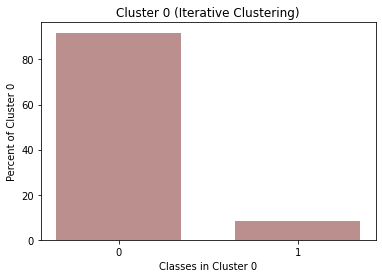

this is the class distribution for cluster: 1

this is the homogeneity Score for this cluster: 0.9081885856079405

Number of points of class 1 in cluster 1: 366 (90.81885856079404)
Number of points of class 0 in cluster 1: 37 (9.181141439205955)


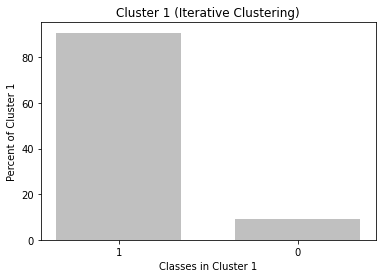

this is the class distribution for cluster: 2

this is the homogeneity Score for this cluster: 0.9583333333333334

Number of points of class 0 in cluster 2: 23 (95.83333333333334)
Number of points of class 1 in cluster 2: 1 (4.166666666666666)


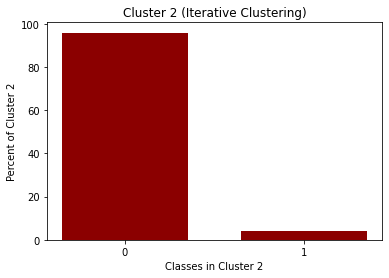

this is the class distribution for cluster: 3

this is the homogeneity Score for this cluster: 1.0

Number of points of class 0 in cluster 3: 32 (100.0)


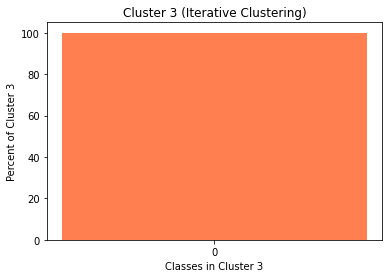

this is the class distribution for cluster: 4

this is the homogeneity Score for this cluster: 0.8

Number of points of class 1 in cluster 4: 28 (80.0)
Number of points of class 0 in cluster 4: 7 (20.0)


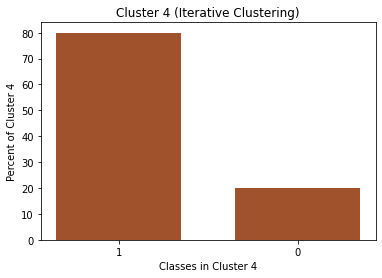

this is the class distribution for cluster: 5

this is the homogeneity Score for this cluster: 0.8333333333333334

Number of points of class 0 in cluster 5: 25 (83.33333333333334)
Number of points of class 1 in cluster 5: 5 (16.666666666666664)


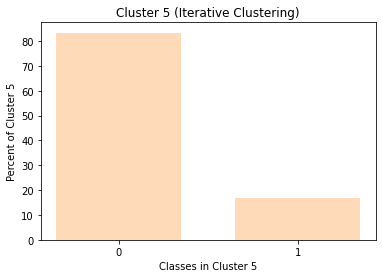

In [ ]:
# Histogram for class distribution of separated clusters
clusterIter = 0
labelDictionary = {0:"0",1:"1",2:"2",3: "3",4 : "4",5 : "5",6 : "Shirt",7 : "Sneaker",8 : "Bag",9 : "Ankle Boot"}
legend = {0: 'rosybrown', 1:'silver', 2: 'darkred', 3:'coral', 4:'sienna', 5:'peachpuff', 6: 'darkorange', 7:'goldenrod', 8:'darkkhaki', 9:'olive', 10:'darkolivegreen', 11:'lawngreen', 12:'darkseagreen', 13:'aquamarine', 14:'darkslategray', 15:'cyan', 16:'dodgerblue', 17:'cornflowerblue', 18:'indigo', 19:'fuchsia', 20:'palevioletred'}


plt.figure(1)
for cluster in separatedClusters:
  print("this is the class distribution for cluster: {}\n".format(clusterIter))
  print("this is the homogeneity Score for this cluster: {}\n".format(scores[clusterIter]))
  numLabelPerCluster = {}
  for i in cluster: #counting number of points per class in cluster
    label = y[i]
    if label in numLabelPerCluster:
      numLabelPerCluster[label] += 1
    else:
      numLabelPerCluster[label] = 1
  
  classesPerCluster = []
  percentageOfClasses = []
  for key in numLabelPerCluster:
    percentage = (numLabelPerCluster[key]/len(cluster))*100
    print("Number of points of class {} in cluster {}: {} ({})".format(labelDictionary[key],clusterIter,numLabelPerCluster[key],percentage))
    classesPerCluster.append(labelDictionary[key])
    percentageOfClasses.append(percentage)
  plt.subplot()
  plt.xticks()
  plt.bar(classesPerCluster, percentageOfClasses,width=.7, align='center',color = legend[clusterIter])
  plt.title("Cluster {} (Iterative Clustering)".format(clusterIter))
  plt.xlabel("Classes in Cluster {}".format(clusterIter))
  plt.ylabel("Percent of Cluster {}".format(clusterIter)) 

  plt.show()

  clusterIter += 1


Number of points of class 0 in remaining: 132 (49.43820224719101)
Number of points of class 1 in remaining: 135 (50.56179775280899)


([0, 1], <a list of 2 Text major ticklabel objects>)

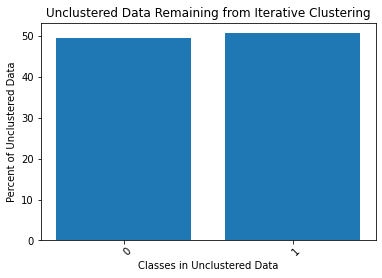

In [ ]:
#Class Distribution for unclustered data from iterative clustering
numLabelsPerClass = {}
for i in remainingPoints:
  label = y[i]
  if label in numLabelsPerClass:
    numLabelsPerClass[label] += 1
  else:
    numLabelsPerClass[label] = 1

classesInRemaining = []
percentagesPerClassForRemaining = []
for key in numLabelsPerClass:
  percentage = (numLabelsPerClass[key]/len(remainingPoints))*100
  print("Number of points of class {} in remaining: {} ({})".format(labelDictionary[key],numLabelsPerClass[key],percentage))
  classesInRemaining.append(labelDictionary[key])
  percentagesPerClassForRemaining.append(percentage)


plt.bar(classesInRemaining, percentagesPerClassForRemaining,align='center')
plt.title("Unclustered Data Remaining from Iterative Clustering")
plt.xlabel("Classes in Unclustered Data")
plt.ylabel("Percent of Unclustered Data")
plt.xticks(rotation=45, rotation_mode='anchor')